# Flagellar Motor Detection in Bacteria Tomograms

In this notebook, we explore the dataset for detecting flagellar motors in bacterial tomograms.

**We will**:
- Set up our environment and reproducibility settings.
- Load and inspect the training labels.
- Examine key statistics including the distribution of motors per tomogram, tomogram sizes, and voxel spacing.
- Visualize sample tomogram slices to get a better feel for the data.
- 
**Let's begin!**
  
# 1) Library and dependecies

In [1]:
import plotly.express as px
from PIL import Image, ImageDraw
import random
import seaborn as sns
from matplotlib.patches import Rectangle
from ultralytics import YOLO
import yaml
import json
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import cv2
import threading
import time
from contextlib import nullcontext
from concurrent.futures import ThreadPoolExecutor
import math
import sys
sys.path.append('d:/flagellar/code/core')
sys.path.append('/flagellar/code/core')
sys.path.append('/flagellar/input/my-flg-library/')
import flg_support as fls
import shutil

## 1.1) Global Constants and Environment Setup

We define paths, create necessary directories, set up the computing device (GPU if available), and fix random seeds for reproducibility.


In [2]:
# Define global constants for dataset directories
DATA_DIR = fls.data_dir
TRAIN_CSV = os.path.join(fls.data_dir, 'train_labels.csv')
TRAIN_DIR = os.path.join(fls.data_dir, 'train')
TEST_DIR = os.path.join(fls.data_dir, 'test')
OUTPUT_DIR = fls.temp_dir + 'yolo_output'
MODEL_DIR = fls.temp_dir + 'yolo_models'
try: shutil.rmtree(OUTPUT_DIR) 
except: pass
try: shutil.rmtree(MODEL_DIR) 
except: pass



# Create output directories if they don't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# Set device: Use GPU if available; otherwise, fall back to CPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True

Using device: cuda


# 2) Exploratory Data Analysis

## 2.1) Loading the Dataset

We load the training labels into a pandas DataFrame and print basic information such as the dataset shape, column names, and descriptive statistics.


In [3]:
# Load the training labels CSV into a pandas DataFrame
train_labels = pd.read_csv(TRAIN_CSV)

# Display basic dataset information
print("Training dataset shape:", train_labels.shape)
print("\nColumns in the dataset:")
print(train_labels.columns.tolist())

# Display basic statistics for numerical columns
print("\nBasic statistics:")
display(train_labels.describe())

Training dataset shape: (737, 10)

Columns in the dataset:
['row_id', 'tomo_id', 'Motor axis 0', 'Motor axis 1', 'Motor axis 2', 'Array shape (axis 0)', 'Array shape (axis 1)', 'Array shape (axis 2)', 'Voxel spacing', 'Number of motors']

Basic statistics:


,row_id,Motor axis 0,Motor axis 1,Motor axis 2,Array shape (axis 0),Array shape (axis 1),Array shape (axis 2),Voxel spacing,Number of motors
count,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000
mean,368.000000,101.861601,294.853460,300.818182,422.651289,950.207598,954.819539,15.341655,1.127544
std,212.897863,102.208293,282.325485,293.368799,174.341523,64.861948,97.229970,2.398197,1.642676
min,0.000000,-1.000000,-1.000000,-1.000000,300.000000,924.000000,924.000000,6.500000,0.000000
25%,184.000000,-1.000000,-1.000000,-1.000000,300.000000,928.000000,928.000000,13.100000,0.000000
50%,368.000000,106.000000,278.000000,280.000000,300.000000,959.000000,928.000000,15.600000,1.000000
75%,552.000000,170.000000,549.000000,567.000000,500.000000,960.000000,956.000000,16.800000,1.000000
max,736.000000,466.000000,904.000000,902.000000,800.000000,1912.000000,1847.000000,19.700000,10.000000


## 2.2) Tomogram and Motor Statistics

We now inspect the unique tomograms in the dataset, and look at the distribution of the number of motors per tomogram.

Additionally, we provide a histogram to visually explore the distribution.



Number of unique tomograms: 648

Distribution of motors per tomogram:
Number of motors
0     286
1     313
2      30
3       6
4       9
6       3
10      1
Name: count, dtype: int64


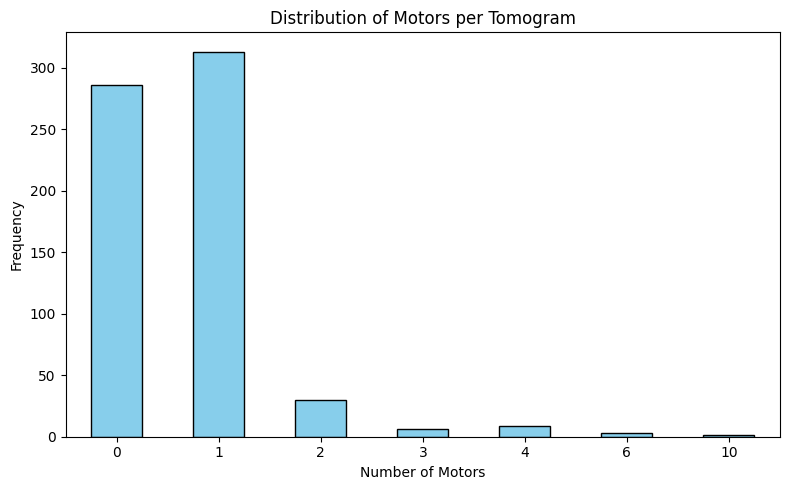

In [4]:
# Count unique tomograms in the dataset
unique_tomo_count = train_labels['tomo_id'].nunique()
print(f"\nNumber of unique tomograms: {unique_tomo_count}")

# Compute distribution of motors per tomogram
motors_per_tomo = train_labels.groupby('tomo_id')['Number of motors'].first().value_counts().sort_index()
print("\nDistribution of motors per tomogram:")
print(motors_per_tomo)

# Visualize the distribution with a bar plot
plt.figure(figsize=(8, 5))
motors_per_tomo.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Motors per Tomogram')
plt.xlabel('Number of Motors')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 2.3) Additional Dataset Insights

We take a closer look at:
- A few sample rows from the training labels.
- Missing values per column.
- The range of tomogram sizes (number of slices and image dimensions).
- The distribution of voxel spacing values.


In [5]:
# Display a few sample rows from the training labels
print("\nSample rows from training labels:")
display(train_labels.head())

# Check for missing values in each column
print("\nMissing values per column:")
display(train_labels.isnull().sum())

# Explore the range of tomogram sizes along each axis
print("\nTomogram size ranges:")
print("Z-axis (slices):", train_labels['Array shape (axis 0)'].min(), "to", train_labels['Array shape (axis 0)'].max())
print("X-axis (width):", train_labels['Array shape (axis 1)'].min(), "to", train_labels['Array shape (axis 1)'].max())
print("Y-axis (height):", train_labels['Array shape (axis 2)'].min(), "to", train_labels['Array shape (axis 2)'].max())

# Display voxel spacing distribution
print("\nVoxel spacing distribution:")
voxel_spacing_counts = train_labels['Voxel spacing'].value_counts().sort_index()
display(voxel_spacing_counts)



Sample rows from training labels:


,row_id,tomo_id,Motor axis 0,Motor axis 1,Motor axis 2,Array shape (axis 0),Array shape (axis 1),Array shape (axis 2),Voxel spacing,Number of motors
0,0,tomo_003acc,-1.0,-1.0,-1.0,500,1912,1847,6.5,0
1,1,tomo_00e047,169.0,546.0,603.0,300,959,928,15.6,1
2,2,tomo_00e463,235.0,403.0,137.0,500,924,956,19.7,6
3,3,tomo_00e463,243.0,363.0,153.0,500,924,956,19.7,6
4,4,tomo_00e463,222.0,379.0,144.0,500,924,956,19.7,6



Missing values per column:


row_id                  0
tomo_id                 0
Motor axis 0            0
Motor axis 1            0
Motor axis 2            0
Array shape (axis 0)    0
Array shape (axis 1)    0
Array shape (axis 2)    0
Voxel spacing           0
Number of motors        0
dtype: int64


Tomogram size ranges:
Z-axis (slices): 300 to 800
X-axis (width): 924 to 1912
Y-axis (height): 924 to 1847

Voxel spacing distribution:


Voxel spacing
6.5       3
13.1    291
13.2      2
13.3     18
15.6    177
16.1     40
16.8     85
19.2      7
19.3     10
19.7    104
Name: count, dtype: int64

## 2.4) Understanding Motor Axis 3D and Data Interpretation

In this section, we visualize the 3D coordinates (Motor axis 0, 1, and 2) of the flagellar motors,
along with other dataset attributes. In 3D scatter plots:

- **Positive Correlation:** When data points on two axes tend to rise together.
- **Negative Correlation:** When one axis increases as the other decreases.
- **Outliers:** Points that fall far from the main cluster.

Each marker represents a row from our dataset, where its position is determined by the motor axis coordinates.

🌀 Motor Axis 3D Visualization & Data Exploration

This section explores motor axis distributions, tomogram shapes, and dataset correlations.
 
- 🟢 **3D Scatter Plots:** Show relationships between motor axes and tomogram shapes.
- 🔥 **Heatmaps & Histograms:** Provide insight into data distributions and correlations.
- 🖼 **Image Grid Views:** Display tomographic slices and bacterial flagellar motors.


In [6]:
fig_motor = px.scatter_3d(
    train_labels, 
    x='Motor axis 0', 
    y='Motor axis 1', 
    z='Motor axis 2',
    color='Number of motors', 
    color_continuous_scale="viridis",  # Using a vibrant color scheme
    size_max=8, 
    width=900, 
    height=600, 
    opacity=0.85, 
    template="plotly_white",  # Lighter theme for better contrast
    title="🚀 3D Scatter Plot: Motor Axes"
)

fig_motor.update_layout(
    font_size=10,
    legend_font_size=14,
    margin=dict(l=10, r=10, b=10, t=40)
)

fig_motor.show()

In [7]:
fig_shape = px.scatter_3d(
    train_labels, 
    x='Array shape (axis 0)', 
    y='Array shape (axis 1)', 
    z='Array shape (axis 2)',
    color='Number of motors', 
    color_continuous_scale="magma",  # More contrast for clarity
    size_max=8, 
    width=900, 
    height=600, 
    opacity=0.85, 
    template="seaborn",  # New theme for a scientific feel
    title="🧬 3D Scatter Plot: Tomogram Shapes"
)

fig_shape.update_layout(
    font_size=10,
    legend_font_size=14,
    margin=dict(l=10, r=10, b=10, t=40)
)

fig_shape.show()

## 2.4.1) Descriptive Statistics and Distribution

Let’s take a look at some basic statistics and the distribution of our features.
We display the mean, minimum, and maximum values of our columns, and create histograms to observe the spread of the data.

,mean,min,max
row_id,368.000000,0.0,736.0
Motor axis 0,101.861601,-1.0,466.0
Motor axis 1,294.853460,-1.0,904.0
Motor axis 2,300.818182,-1.0,902.0
Array shape (axis 0),422.651289,300.0,800.0
Array shape (axis 1),950.207598,924.0,1912.0
Array shape (axis 2),954.819539,924.0,1847.0
Voxel spacing,15.341655,6.5,19.7
Number of motors,1.127544,0.0,10.0


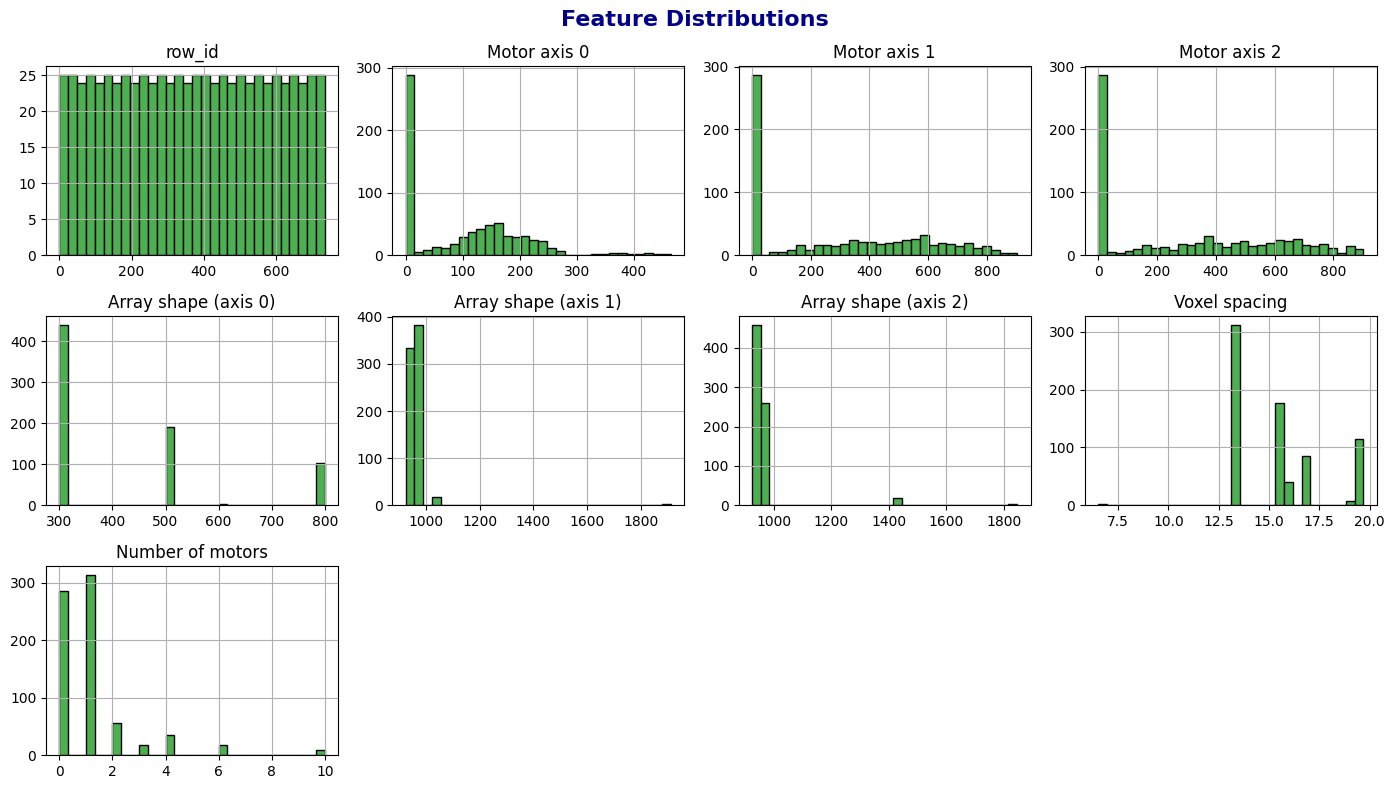

In [8]:
# Show descriptive statistics
display(train_labels.describe().loc[['mean', 'min', 'max']].T)

# Improved histogram design
train_labels.hist(
    bins=30, 
    figsize=(14, 8), 
    layout=(3, 4), 
    edgecolor="black", 
    color="#4CAF50"  # Greenish color theme
)
plt.suptitle("Feature Distributions", fontsize=16, fontweight='bold', color="darkblue")
plt.tight_layout()


## 2.4.2) Correlation Matrix

A correlation matrix helps you see how features relate to each other.

- **Positive values:** Indicate that as one variable increases, the other tends to increase.
- **Negative values:** Indicate that as one variable increases, the other tends to decrease.

The heatmap below visualizes the correlations in our dataset.

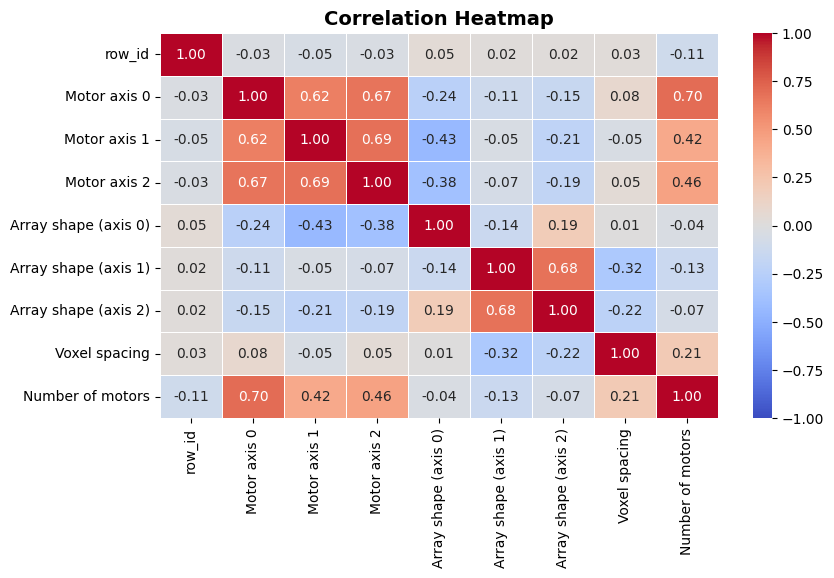

In [9]:
plt.figure(figsize=(9, 5), facecolor="white")
sns.heatmap(
    data=train_labels.corr(numeric_only=True),
    cmap="coolwarm",  # Strong contrast for positive/negative correlations
    vmin=-1, vmax=1,
    linecolor="white", linewidth=0.6,
    annot=True,
    fmt=".2f"
)
plt.title('Correlation Heatmap', fontsize=14, fontweight='bold', color="black")
plt.show()

## 2.4.3) Visualizing Images from the Dataset

Visual inspection of the tomographic slices can be very helpful. The functions below load and display a grid of images.

There are two functions:

- **plotImages:** Displays a grid of images from a given directory (for both training and test images).
- **visualize_images:** A more flexible function that randomly selects a number of images to show.

Both functions resize images for consistency and hide axis ticks for a cleaner look.

In [10]:
def plotImages(title, directory, n_images=16, img_size=(128, 128)):
    """
    Display a grid of images from the specified directory.
    
    Args:
        title (str): Title to print before displaying images.
        directory (str): Glob pattern for image files.
        n_images (int): Number of images to display.
        img_size (tuple): Size to resize images for display.
    """
    print(f"🖼 {title}")
    image_files = glob.glob(directory)
    
    if not image_files:
        print("No images found.")
        return
    
    plt.figure(figsize=(12, 12))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    
    for i, file_path in enumerate(image_files[:n_images]):
        img = cv2.imread(file_path)
        if img is None:
            continue
        img = cv2.resize(img, img_size)
        plt.subplot(4, 4, i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    
    plt.suptitle(title, fontsize=14, fontweight='bold', color="darkred")
    plt.show()

plotImages("Bacterial Flagellar Motors - Train Images", "../input/byu-locating-bacterial-flagellar-motors-2025/train/***/**")


🖼 Bacterial Flagellar Motors - Train Images
No images found.


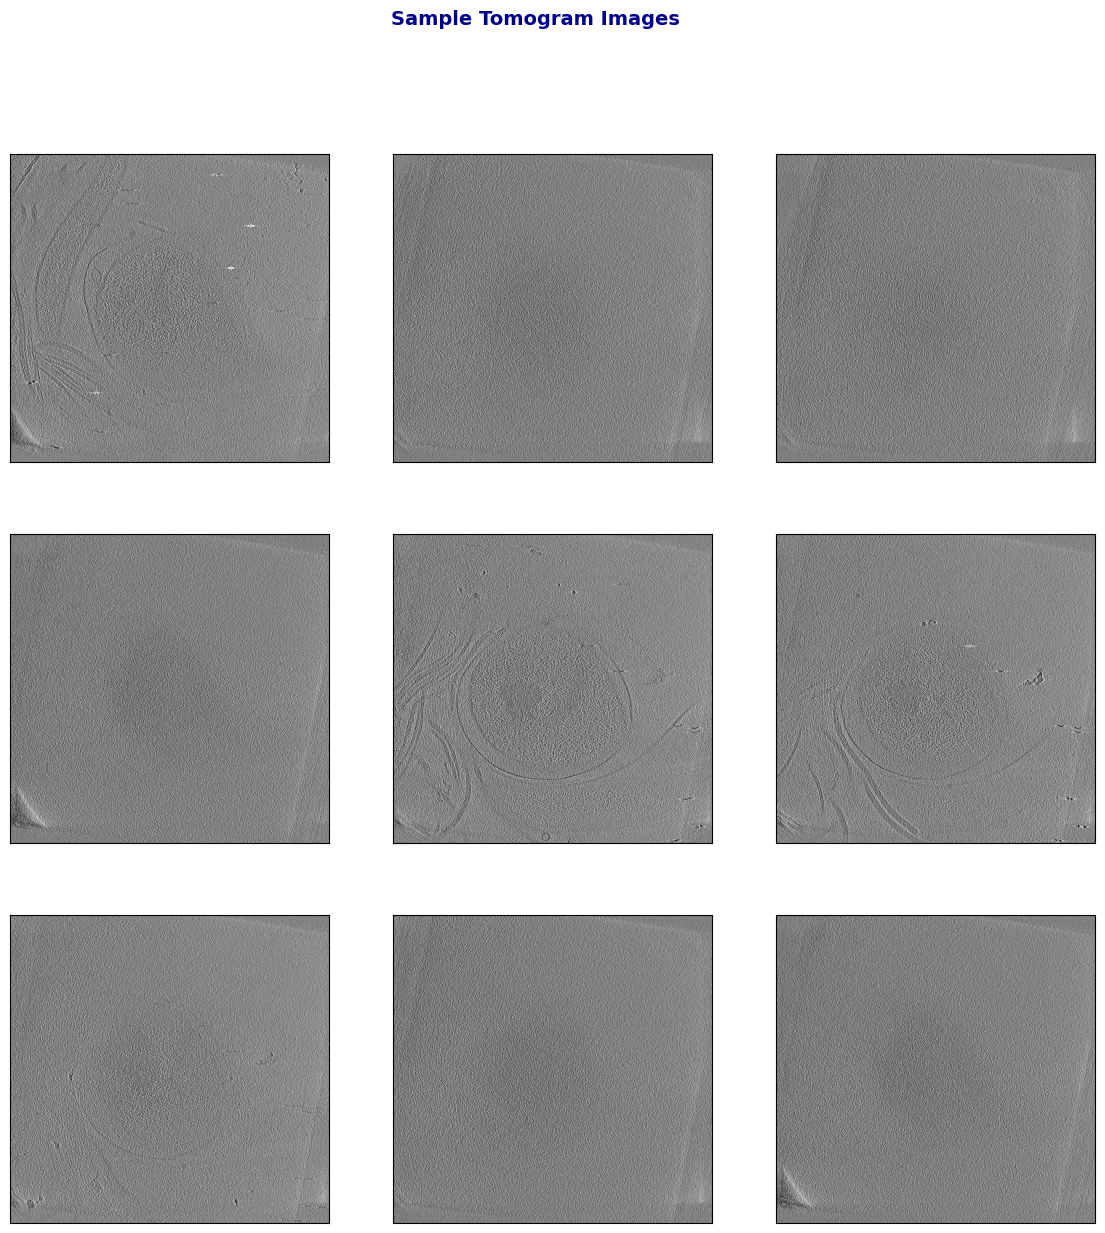

In [11]:
def visualize_images(path, n_images=12, is_random=True, figsize=(14, 14)):
    """
    Visualize a set of images from a directory.
    
    Args:
        path (str): Directory path containing images.
        n_images (int): Number of images to display.
        is_random (bool): If True, display random images; else, the first n_images.
        figsize (tuple): Size of the figure.
    """
    plt.figure(figsize=figsize)
    
    image_names = os.listdir(path)
    if is_random:
        image_names = random.sample(image_names, min(len(image_names), n_images))
    else:
        image_names = image_names[:n_images]
    
    w = int(math.sqrt(n_images))
    h = math.ceil(n_images / w)
    
    for ind, image_name in enumerate(image_names):
        img_path = os.path.join(path, image_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(h, w, ind + 1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    
    plt.suptitle("Sample Tomogram Images", fontsize=14, fontweight='bold', color="darkblue")
    plt.show()

visualize_images(TRAIN_DIR + "/tomo_098751", n_images=9)


Visualizing sample tomogram: tomo_003acc
Number of slice files in tomogram 'tomo_003acc': 500
Dimensions of a sample slice: (1847, 1912)


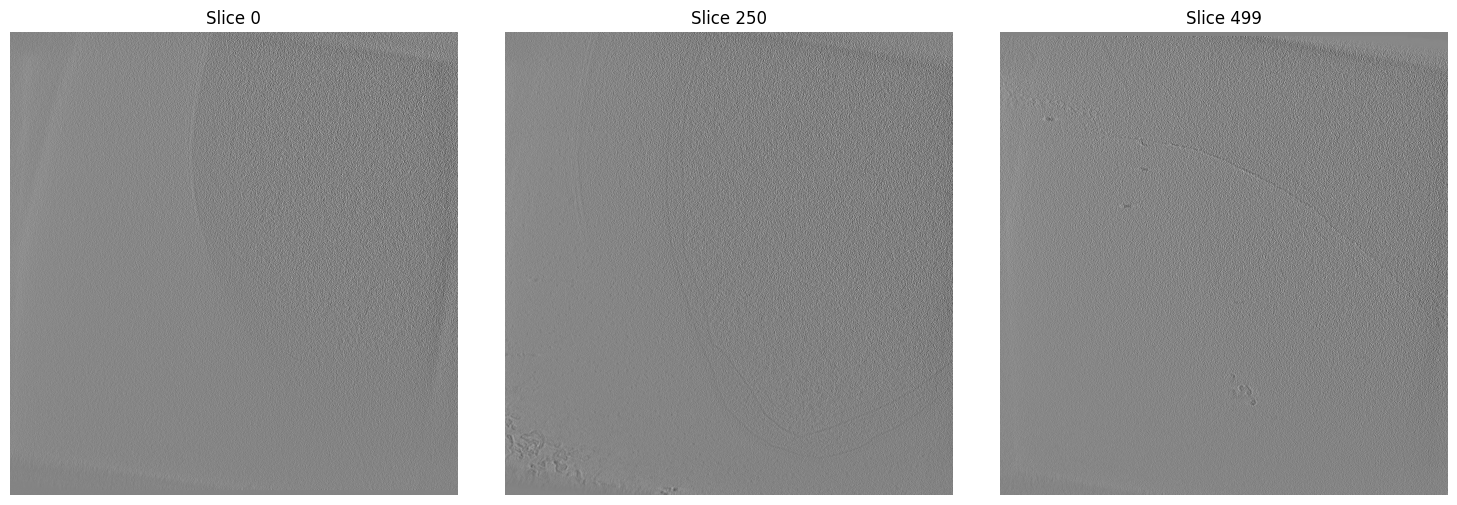

In [12]:
# Select a sample tomogram ID to visualize
sample_tomo_id = train_labels['tomo_id'].iloc[0]
print(f"\nVisualizing sample tomogram: {sample_tomo_id}")

# Construct the folder path for the selected tomogram
sample_folder = os.path.join(TRAIN_DIR, sample_tomo_id)

if os.path.exists(sample_folder):
    # Get all JPEG slice files from the tomogram folder
    slice_files = sorted(glob.glob(os.path.join(sample_folder, '*.jpg')))
    print(f"Number of slice files in tomogram '{sample_tomo_id}': {len(slice_files)}")
    
    if slice_files:
        # Load the first slice to check its dimensions
        sample_slice = Image.open(slice_files[0])
        print(f"Dimensions of a sample slice: {sample_slice.size}")
        
        # Plot slices from the beginning, middle, and end of the tomogram
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        slice_indices = [0, len(slice_files)//2, len(slice_files)-1]
        for i, idx in enumerate(slice_indices):
            img = Image.open(slice_files[idx])
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f"Slice {idx}")
            axes[i].axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("No slice files found in the folder.")
else:
    print(f"Folder '{sample_folder}' does not exist. Please check the dataset directory.")


## Summary

📌 Final Summary

✔ Enhanced 3D scatter plots with new colors, themes, and better interactivity.

✔ Improved histograms & heatmaps using more intuitive colormaps.

✔ Refined image display functions for a better layout and readability.

✔ Added titles, spacing, and comments to make everything beginner-friendly.

# 3) **YOLO**

## 3.1) Data Preprocessing for YOLO Dataset Preparation

In this section, we:

- **Load Motor Annotations:** Read the tomogram and motor location annotations.
- **Slice Extraction:** For each motor, extract 2D slices (with a configurable range above and below the motor slice).
- **Image Normalization:** Normalize each slice using percentile-based contrast enhancement.
- **Dataset Organization:** Save the normalized images and generate YOLO-format bounding box annotations.
- **Train/Validation Split:** Split the data by tomogram to avoid any overlap between training and validation sets.
- **Configuration File Generation:** Create a `dataset.yaml` file for YOLO training.


In [13]:
# Define YOLO dataset structure and parameters
data_path = DATA_DIR
train_dir = os.path.join(data_path, "train")

# Output directories for YOLO dataset (adjust as needed)
yolo_dataset_dir = fls.temp_dir + '/yolo_dataset/'
yolo_images_train = os.path.join(yolo_dataset_dir, "images", "train")
yolo_images_val = os.path.join(yolo_dataset_dir, "images", "val")
yolo_labels_train = os.path.join(yolo_dataset_dir, "labels", "train")
yolo_labels_val = os.path.join(yolo_dataset_dir, "labels", "val")

# Create necessary directories
for dir_path in [yolo_images_train, yolo_images_val, yolo_labels_train, yolo_labels_val]:
    try: shutil.rmtree(dir_path)
    except: pass
    os.makedirs(dir_path, exist_ok=True)

# Define constants for processing
TRUST = 4       # Number of slices above and below center slice (total slices = 2*TRUST + 1)
BOX_SIZE = 24   # Bounding box size (in pixels)
TRAIN_SPLIT = 0.8  # 80% training, 20% validation

# Define a helper function for image normalization using percentile-based contrast enhancement.
def normalize_slice(slice_data):
    """
    Normalize slice data using the 2nd and 98th percentiles.
    
    Args:
        slice_data (numpy.array): Input image slice.
    
    Returns:
        np.uint8: Normalized image in the range [0, 255].
    """
    p2 = np.percentile(slice_data, 2)
    p98 = np.percentile(slice_data, 98)
    clipped_data = np.clip(slice_data, p2, p98)
    normalized = 255 * (clipped_data - p2) / (p98 - p2)
    return np.uint8(normalized)

# Define the preprocessing function to extract slices, normalize, and generate YOLO annotations.
def prepare_yolo_dataset(trust=TRUST, train_split=TRAIN_SPLIT):
    """
    Extract slices containing motors and save images with corresponding YOLO annotations.
    
    Steps:
    - Load the motor labels.
    - Perform a train/validation split by tomogram.
    - For each motor, extract slices in a range (± trust parameter).
    - Normalize each slice and save it.
    - Generate YOLO format bounding box annotations with a fixed box size.
    - Create a YAML configuration file for YOLO training.
    
    Returns:
        dict: A summary containing dataset statistics and file paths.
    """
    # Load the labels CSV
    labels_df = pd.read_csv(os.path.join(data_path, "train_labels.csv"))
    
    total_motors = labels_df['Number of motors'].sum()
    print(f"Total number of motors in the dataset: {total_motors}")
    
    # Consider only tomograms with at least one motor
    tomo_df = labels_df[labels_df['Number of motors'] > 0].copy()
    unique_tomos = tomo_df['tomo_id'].unique()
    print(f"Found {len(unique_tomos)} unique tomograms with motors")
    
    # Shuffle and split tomograms into train and validation sets
    #np.random.shuffle(unique_tomos)
    #split_idx = int(len(unique_tomos) * train_split)s
    #train_tomos = unique_tomos[:split_idx]
    #val_tomos = unique_tomos[split_idx:]
    import sys
    sys.path.append('/flagellar/code/core/')
    import flg_support as fls
    train_tomos_init,val_tomos_init = fls.dill_load(fls.temp_dir + 'repr.pickle')    

    train_tomos = []
    for t in train_tomos_init:
        if t in unique_tomos:
            train_tomos.append(t)
    val_tomos = []
    for t in val_tomos_init:
        if t in unique_tomos:
            val_tomos.append(t)

    print(f"Split: {len(train_tomos)} tomograms for training, {len(val_tomos)} tomograms for validation")
    
    
    # Helper function to process a list of tomograms
    def process_tomogram_set(tomogram_ids, images_dir, labels_dir, set_name):
        motor_counts = []
        for tomo_id in tomogram_ids:
            # Get motor annotations for the current tomogram
            tomo_motors = labels_df[labels_df['tomo_id'] == tomo_id]
            for _, motor in tomo_motors.iterrows():
                if pd.isna(motor['Motor axis 0']):
                    continue
                motor_counts.append(
                    (tomo_id, 
                     int(motor['Motor axis 0']), 
                     int(motor['Motor axis 1']), 
                     int(motor['Motor axis 2']),
                     int(motor['Array shape (axis 0)']))
                )
        
        print(f"Will process approximately {len(motor_counts) * (2 * trust + 1)} slices for {set_name}")
        processed_slices = 0
        
        # Loop over each motor annotation
        for tomo_id, z_center, y_center, x_center, z_max in tqdm(motor_counts, desc=f"Processing {set_name} motors"):
            z_min = max(0, z_center - trust)
            z_max_bound = min(z_max - 1, z_center + trust)
            for z in range(z_min, z_max_bound + 1):
                # Create the slice filename and source path
                slice_filename = f"slice_{z:04d}.jpg"
                src_path = os.path.join(train_dir, tomo_id, slice_filename)
                if not os.path.exists(src_path):
                    print(f"Warning: {src_path} does not exist, skipping.")
                    continue
                
                # Load, normalize, and save the image slice
                img = Image.open(src_path)
                img_array = np.array(img)
                normalized_img = normalize_slice(img_array)
                dest_filename = f"{tomo_id}_z{z:04d}_y{y_center:04d}_x{x_center:04d}.jpg"
                dest_path = os.path.join(images_dir, dest_filename)
                Image.fromarray(normalized_img).save(dest_path)
                
                # Prepare YOLO bounding box annotation (normalized values)
                img_width, img_height = img.size
                x_center_norm = x_center / img_width
                y_center_norm = y_center / img_height
                box_width_norm = BOX_SIZE / img_width
                box_height_norm = BOX_SIZE / img_height
                label_path = os.path.join(labels_dir, dest_filename.replace('.jpg', '.txt'))
                with open(label_path, 'w') as f:
                    f.write(f"0 {x_center_norm} {y_center_norm} {box_width_norm} {box_height_norm}\n")
                
                processed_slices += 1
        
        return processed_slices, len(motor_counts)
    
    # Process training tomograms
    train_slices, train_motors = process_tomogram_set(train_tomos, yolo_images_train, yolo_labels_train, "training")
    # Process validation tomograms
    val_slices, val_motors = process_tomogram_set(val_tomos, yolo_images_val, yolo_labels_val, "validation")
    
    # Generate YAML configuration for YOLO training
    yaml_content = {
        'path': yolo_dataset_dir,
        'train': 'images/train',
        'val': 'images/val',
        'names': {0: 'motor'}
    }
    with open(os.path.join(yolo_dataset_dir, 'dataset.yaml'), 'w') as f:
        yaml.dump(yaml_content, f, default_flow_style=False)
    
    print(f"\nProcessing Summary:")
    print(f"- Train set: {len(train_tomos)} tomograms, {train_motors} motors, {train_slices} slices")
    print(f"- Validation set: {len(val_tomos)} tomograms, {val_motors} motors, {val_slices} slices")
    print(f"- Total: {len(train_tomos) + len(val_tomos)} tomograms, {train_motors + val_motors} motors, {train_slices + val_slices} slices")
    
    return {
        "dataset_dir": yolo_dataset_dir,
        "yaml_path": os.path.join(yolo_dataset_dir, 'dataset.yaml'),
        "train_tomograms": len(train_tomos),
        "val_tomograms": len(val_tomos),
        "train_motors": train_motors,
        "val_motors": val_motors,
        "train_slices": train_slices,
        "val_slices": val_slices
    }

# Run the preprocessing
summary = prepare_yolo_dataset(TRUST)
print(f"\nPreprocessing Complete:")
print(f"- Training data: {summary['train_tomograms']} tomograms, {summary['train_motors']} motors, {summary['train_slices']} slices")
print(f"- Validation data: {summary['val_tomograms']} tomograms, {summary['val_motors']} motors, {summary['val_slices']} slices")
print(f"- Dataset directory: {summary['dataset_dir']}")
print(f"- YAML configuration: {summary['yaml_path']}")
print("\nReady for YOLO training!")

Total number of motors in the dataset: 831
Found 362 unique tomograms with motors
Split: 258 tomograms for training, 100 tomograms for validation
Will process approximately 3123 slices for training


Processing training motors:   0%|          | 0/347 [00:00<?, ?it/s]

Will process approximately 900 slices for validation


Processing validation motors:   0%|          | 0/100 [00:00<?, ?it/s]


Processing Summary:
- Train set: 258 tomograms, 347 motors, 3118 slices
- Validation set: 100 tomograms, 100 motors, 900 slices
- Total: 358 tomograms, 447 motors, 4018 slices

Preprocessing Complete:
- Training data: 258 tomograms, 347 motors, 3118 slices
- Validation data: 100 tomograms, 100 motors, 900 slices
- Dataset directory: /flagellar/temp//yolo_dataset/
- YAML configuration: /flagellar/temp//yolo_dataset/dataset.yaml

Ready for YOLO training!


## 3.2) Visualization of Preprocessed Data

In this final section, we validate our preprocessing steps by visualizing random training samples along with their YOLO annotations.
This allows us to inspect the bounding box placements and verify that the data is ready for model training.


## 3.3) YOLOv8 Training Pipeline for Flagellar Motor Detection

This notebook implements a full YOLOv8 training pipeline for detecting bacterial flagellar motors in tomographic slices.

**Overview:**
- **Dataset Configuration:** Sets up and validates the YOLO-format dataset YAML file.
- **Model Initialization:** Loads pre-trained YOLOv8 weights for transfer learning.
- **Training Process:** Fine tunes the model with early stopping and periodic checkpoints.
- **Loss Visualization:** Plots training and validation DFL loss curves to monitor progress.
- **Performance Evaluation:** Tests the trained model on random validation samples.
- **Model Export:** Saves the trained weights for later use.

Let's begin by importing the necessary libraries and setting up reproducibility.


In [14]:
# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Define paths for the Kaggle environment
yolo_weights_dir = fls.temp_dir + '/yolo_weights'
yolo_pretrained_weights = "/kaggle/input/ultralytics-for-offline-install/yolov8m.pt"  # Pre-downloaded weights

# Create a directory to store the weights
os.makedirs(yolo_weights_dir, exist_ok=True)

# This will download the YOLOv8 nano weights
model = YOLO("yolov8m.pt")

# Save the downloaded weights to a local file
model.save(yolo_weights_dir + "yolov8m.pt")

## 3.4) Dataset Configuration and YAML Fixing

The function below reads the original YAML file and fixes the paths to match the actual Kaggle directory structure.

- **fix_yaml_paths:** Reads the dataset YAML file, updates the 'path' entry, and writes a fixed version to the working directory.

In [15]:
def fix_yaml_paths(yaml_path):
    """
    Fix the paths in the YAML file to match the actual Kaggle directories.
    
    Args:
        yaml_path (str): Path to the original dataset YAML file.
        
    Returns:
        str: Path to the fixed YAML file.
    """
    print(f"Fixing YAML paths in {yaml_path}")
    with open(yaml_path, 'r') as f:
        yaml_data = yaml.safe_load(f)
    
    if 'path' in yaml_data:
        yaml_data['path'] = yolo_dataset_dir
    
    fixed_yaml_path = fls.temp_dir + "fixed_dataset.yaml"
    with open(fixed_yaml_path, 'w') as f:
        yaml.dump(yaml_data, f)
    
    print(f"Created fixed YAML at {fixed_yaml_path} with path: {yaml_data.get('path')}")
    return fixed_yaml_path

## 3.5) Loss Curve Visualization

After training, we want to see how the DFL (Distribution Focal Loss) changes over epochs. The function below reads the `results.csv` file from the training run and plots the training and validation DFL loss curves.

- **plot_dfl_loss_curve:** Reads the results CSV, finds the epoch with the best validation loss, plots both curves, and saves the plot.

In [16]:
def plot_dfl_loss_curve(run_dir):
    """
    Plot the DFL loss curves for training and validation, marking the best model.
    
    Args:
        run_dir (str): Directory where the training results are stored.
    """
    results_csv = os.path.join(run_dir, 'results.csv')
    if not os.path.exists(results_csv):
        print(f"Results file not found at {results_csv}")
        return
    
    results_df = pd.read_csv(results_csv)
    train_dfl_col = [col for col in results_df.columns if 'train/dfl_loss' in col]
    val_dfl_col = [col for col in results_df.columns if 'val/dfl_loss' in col]
    
    if not train_dfl_col or not val_dfl_col:
        print("DFL loss columns not found in results CSV")
        print(f"Available columns: {results_df.columns.tolist()}")
        return
    
    train_dfl_col = train_dfl_col[0]
    val_dfl_col = val_dfl_col[0]
    
    best_epoch = results_df[val_dfl_col].idxmin()
    best_val_loss = results_df.loc[best_epoch, val_dfl_col]
    
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['epoch'], results_df[train_dfl_col], label='Train DFL Loss')
    plt.plot(results_df['epoch'], results_df[val_dfl_col], label='Validation DFL Loss')
    plt.axvline(x=results_df.loc[best_epoch, 'epoch'], color='r', linestyle='--', 
                label=f'Best Model (Epoch {int(results_df.loc[best_epoch, "epoch"])}, Val Loss: {best_val_loss:.4f})')
    plt.xlabel('Epoch')
    plt.ylabel('DFL Loss')
    plt.title('Training and Validation DFL Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plot_path = os.path.join(run_dir, 'dfl_loss_curve.png')
    plt.savefig(plot_path)
    plt.savefig(os.path.join('/kaggle/working', 'dfl_loss_curve.png'))
    
    print(f"Loss curve saved to {plot_path}")
    plt.close()
    
    return best_epoch, best_val_loss

## 3.6) Model Training Function

This function sets up and trains the YOLOv8 model using the fixed YAML file, with early stopping and checkpoint saving.

- **train_yolo_model:** Loads the pre-trained weights, trains the model for a specified number of epochs, and returns the trained model along with training results.

## 3.7) Prediction on Validation Samples

After training, we can quickly test the model on random validation samples to see how the predictions compare with the ground truth.

- **predict_on_samples:** Runs predictions on a few images from the validation set and overlays both the ground truth (if available) and the predicted bounding boxes.

In [17]:
import os
from ultralytics import YOLO

def train_yolo_model(yaml_path, pretrained_weights_path, epochs=50, batch_size=16, img_size=640):
    """
    Train a YOLO model on the prepared dataset with optimized accuracy settings.

    Args:
        yaml_path (str): Path to the dataset YAML file.
        pretrained_weights_path (str): Path to pre-downloaded weights file.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
        img_size (int): Image size for training.

    Returns:
        model (YOLO): Trained YOLO model.
        results: Training results.
    """
    print(f"Loading pre-trained weights from: {pretrained_weights_path}")
    model = YOLO(pretrained_weights_path)

    results = model.train(
        data=yaml_path,
        epochs=epochs,
        batch=batch_size,
        imgsz=img_size,
        project=yolo_weights_dir,
        name='motor_detector',
        exist_ok=True,
        patience=10,  # Stop training if no improvement after 10 epochs
        save_period=5,  # Save model every 5 epochs
        val=True,
        verbose=True,
        optimizer="AdamW",  # AdamW optimizer for stability
        lr0=0.001,  # Initial learning rate
        lrf=0.01,  # Final learning rate factor
        cos_lr=True,  # Use cosine learning rate decay
        weight_decay=0.0005,  # Prevent overfitting
        momentum=0.937,  # Momentum for better gradient updates
        close_mosaic=10,  # Disable mosaic augmentation after 10 epochs
        mixup=0.2,  # Apply mixup augmentation
        workers=4,  # Speed up data loading
        augment=True,  # Enable additional augmentations
        amp=True,  # Mixed precision training for faster performance
    )

    run_dir = os.path.join(yolo_weights_dir, 'motor_detector')
    
    # If function is defined, plot loss curves for better insights
    if 'plot_dfl_loss_curve' in globals():
        best_epoch_info = plot_dfl_loss_curve(run_dir)
        if best_epoch_info:
            best_epoch, best_val_loss = best_epoch_info
            print(f"\nBest model found at epoch {best_epoch} with validation DFL loss: {best_val_loss:.4f}")

    return model, results


In [18]:

def predict_on_samples(model, num_samples=4):
    """
    Run predictions on random validation samples and display results.
    
    Args:
        model: Trained YOLO model.
        num_samples (int): Number of random samples to test.
    """
    val_dir = os.path.join(yolo_dataset_dir, 'images', 'val')
    if not os.path.exists(val_dir):
        print(f"Validation directory not found at {val_dir}")
        val_dir = os.path.join(yolo_dataset_dir, 'images', 'train')
        print(f"Using train directory for predictions instead: {val_dir}")
        
    if not os.path.exists(val_dir):
        print("No images directory found for predictions")
        return
    
    val_images = os.listdir(val_dir)
    if len(val_images) == 0:
        print("No images found for prediction")
        return
    
    num_samples = min(num_samples, len(val_images))
    samples = random.sample(val_images, num_samples)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()
    
    for i, img_file in enumerate(samples):
        if i >= len(axes):
            break
            
        img_path = os.path.join(val_dir, img_file)
        results = model.predict(img_path, conf=0.25)[0]
        img = Image.open(img_path)
        axes[i].imshow(np.array(img), cmap='gray')
        
        # Draw ground truth box if available (extracted from filename)
        try:
            parts = img_file.split('_')
            y_part = [p for p in parts if p.startswith('y')]
            x_part = [p for p in parts if p.startswith('x')]
            if y_part and x_part:
                y_gt = int(y_part[0][1:])
                x_gt = int(x_part[0][1:].split('.')[0])
                box_size = 24
                rect_gt = Rectangle((x_gt - box_size//2, y_gt - box_size//2), box_size, box_size,
                                      linewidth=1, edgecolor='g', facecolor='none')
                axes[i].add_patch(rect_gt)
        except:
            pass
        
        if len(results.boxes) > 0:
            boxes = results.boxes.xyxy.cpu().numpy()
            confs = results.boxes.conf.cpu().numpy()
            for box, conf in zip(boxes, confs):
                x1, y1, x2, y2 = box
                rect_pred = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
                axes[i].add_patch(rect_pred)
                axes[i].text(x1, y1-5, f'{conf:.2f}', color='red')
        
        axes[i].set_title(f"Image: {img_file}\nGT (green) vs Pred (red)")
    
    plt.tight_layout()
    plt.savefig(os.path.join('/kaggle/working', 'predictions.png'))
    plt.show()

## 3.8) Dataset YAML Preparation and Main Training Execution

Before training, we check if the dataset directories exist and either fix or create a new YAML file.

- **prepare_dataset:** Checks for directories and a YAML file, fixes the paths if necessary, or creates a new YAML file.

Finally, the **main** function runs the complete training process and then tests the model on sample images.

Starting YOLO training process...
Directory status:
- Train images exists: True
- Val images exists: True
- Train labels exists: True
- Val labels exists: True
Found original dataset.yaml at /flagellar/temp//yolo_dataset/dataset.yaml
Fixing YAML paths in /flagellar/temp//yolo_dataset/dataset.yaml
Created fixed YAML at /flagellar/temp/fixed_dataset.yaml with path: /flagellar/temp//yolo_dataset/
Using YAML file: /flagellar/temp/fixed_dataset.yaml
YAML contents:
names:
  0: motor
path: /flagellar/temp//yolo_dataset/
train: images/train
val: images/val


Starting YOLO training...
Loading pre-trained weights from: /kaggle/input/ultralytics-for-offline-install/yolov8m.pt
Ultralytics 8.3.98 🚀 Python-3.11.10 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 23995MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/input/ultralytics-for-offline-install/yolov8m.pt, data=/flagellar/temp/fixed_dataset.yaml, epochs=5, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=5, ca

train: Scanning /flagellar/temp/yolo_dataset/labels/train... 3118 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3118/3118 [00:01<00:00, 1880.70it/s]


train: New cache created: /flagellar/temp/yolo_dataset/labels/train.cache


val: Scanning /flagellar/temp/yolo_dataset/labels/val... 900 images, 0 backgrounds, 0 corrupt: 100%|██████████| 900/900 [00:00<00:00, 3087.77it/s]


val: New cache created: /flagellar/temp/yolo_dataset/labels/val.cache
Plotting labels to /flagellar/temp/yolo_weights/motor_detector/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /flagellar/temp/yolo_weights/motor_detector
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.33G      3.239      5.545      1.254         20        640: 100%|██████████| 195/195 [00:26<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:03<00:00,  7.55it/s]

                   all        900        900     0.0248     0.0511    0.00468   0.000742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.25G      2.508      2.048      1.035         29        640: 100%|██████████| 195/195 [00:24<00:00,  8.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:03<00:00,  7.85it/s]


                   all        900        900      0.321      0.355       0.17     0.0338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.25G      2.292      1.818     0.9935         22        640: 100%|██████████| 195/195 [00:23<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:03<00:00,  7.55it/s]


                   all        900        900      0.675      0.623      0.652      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.25G      2.075      1.564     0.9542         13        640: 100%|██████████| 195/195 [00:24<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:03<00:00,  7.74it/s]

                   all        900        900      0.774      0.684       0.72        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.25G      1.871      1.331     0.9139         26        640: 100%|██████████| 195/195 [00:24<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:03<00:00,  7.83it/s]

                   all        900        900      0.823      0.778      0.818      0.244



5 epochs completed in 0.041 hours.
Optimizer stripped from /flagellar/temp/yolo_weights/motor_detector/weights/last.pt, 52.0MB
Optimizer stripped from /flagellar/temp/yolo_weights/motor_detector/weights/best.pt, 52.0MB

Validating /flagellar/temp/yolo_weights/motor_detector/weights/best.pt...
Ultralytics 8.3.98 🚀 Python-3.11.10 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 23995MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  4.05it/s]


                   all        900        900      0.679      0.757      0.772      0.279
Speed: 0.1ms preprocess, 4.3ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /flagellar/temp/yolo_weights/motor_detector


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/dfl_loss_curve.png'

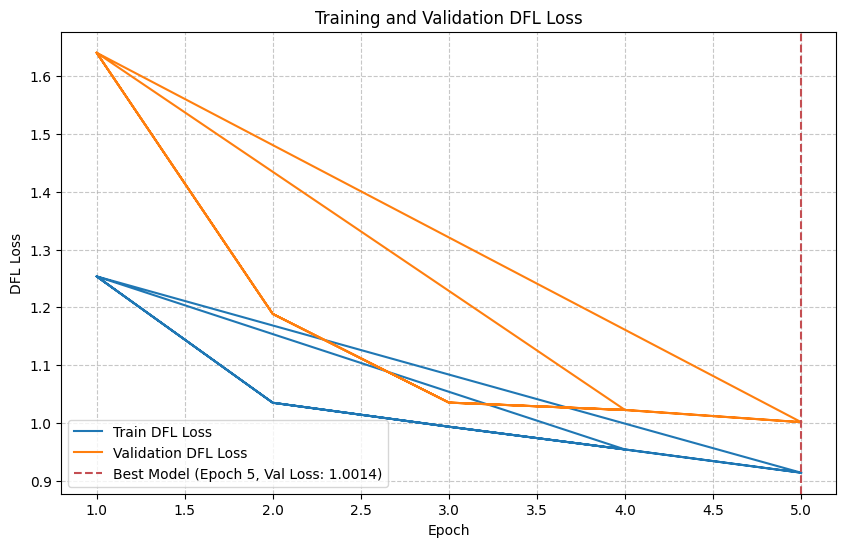

In [19]:
def prepare_dataset():
    """
    Check if the dataset exists and create/fix a proper YAML file for training.
    
    Returns:
        str: Path to the YAML file to use for training.
    """
    train_images_dir = os.path.join(yolo_dataset_dir, 'images', 'train')
    val_images_dir = os.path.join(yolo_dataset_dir, 'images', 'val')
    train_labels_dir = os.path.join(yolo_dataset_dir, 'labels', 'train')
    val_labels_dir = os.path.join(yolo_dataset_dir, 'labels', 'val')
    
    print(f"Directory status:")
    print(f"- Train images exists: {os.path.exists(train_images_dir)}")
    print(f"- Val images exists: {os.path.exists(val_images_dir)}")
    print(f"- Train labels exists: {os.path.exists(train_labels_dir)}")
    print(f"- Val labels exists: {os.path.exists(val_labels_dir)}")
    
    original_yaml_path = os.path.join(yolo_dataset_dir, 'dataset.yaml')
    if os.path.exists(original_yaml_path):
        print(f"Found original dataset.yaml at {original_yaml_path}")
        return fix_yaml_paths(original_yaml_path)
    else:
        print("Original dataset.yaml not found, creating a new one")
        yaml_data = {
            'path': yolo_dataset_dir,
            'train': 'images/train',
            'val': 'images/train' if not os.path.exists(val_images_dir) else 'images/val',
            'names': {0: 'motor'}
        }
        new_yaml_path = "/kaggle/working/dataset.yaml"
        with open(new_yaml_path, 'w') as f:
            yaml.dump(yaml_data, f)
        print(f"Created new YAML at {new_yaml_path}")
        return new_yaml_path

def main():
    print("Starting YOLO training process...")
    yaml_path = prepare_dataset()
    print(f"Using YAML file: {yaml_path}")
    with open(yaml_path, 'r') as f:
        print(f"YAML contents:\n{f.read()}")
    
    print("\nStarting YOLO training...")
    model, results = train_yolo_model(
        yaml_path,
        pretrained_weights_path=yolo_pretrained_weights,
        epochs=5  # For demonstration, using 30 epochs
    )
    
    print("\nTraining complete!")
    print("\nRunning predictions on sample images...")
    predict_on_samples(model, num_samples=4)

if __name__ == "__main__":
    main()



# 4) YOLOv8 Inference & Submission Pipeline

This section implements an optimized inference pipeline for generating submissions.

**Overview:**
- **Offline Execution:** The notebook is designed to run offline using a local copy of the Ultralytics YOLOv8 package.
- **Model Loading:** Loads the best trained YOLOv8 weights.
- **GPU Optimization:** Configures CUDA optimizations, half-precision inference, and dynamic batch sizing.
- **Parallel Processing:** Uses CUDA streams and preloading to speed up processing.
- **3D Detection:** Processes each tomographic slice and applies 3D Non-Maximum Suppression (NMS).
- **Submission Generation:** Creates a final CSV with predicted motor coordinates.

## 4.1) Setting Up Inference Libraries

We import additional libraries and set up some GPU and batch parameters for efficient inference.

In [20]:
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Define paths for the test data and submission
data_path = fls.data_dir
test_dir = os.path.join(data_path, "test")
submission_path = fls.output_dir + "submission.csv"

# Path to the best trained model (adjust if necessary)
model_path = yolo_weights_dir + "/motor_detector/weights/best.pt"

# Define detection and processing parameters
CONFIDENCE_THRESHOLD = 0.45
MAX_DETECTIONS_PER_TOMO = 3
NMS_IOU_THRESHOLD = 0.2
CONCENTRATION = 1  # Process a fraction of slices for fast submission

# GPU profiling context manager for timing
class GPUProfiler:
    def __init__(self, name):
        self.name = name
        self.start_time = None
        
    def __enter__(self):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        self.start_time = time.time()
        return self
        
    def __exit__(self, *args):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        elapsed = time.time() - self.start_time
        print(f"[PROFILE] {self.name}: {elapsed:.3f}s")

# Set device and dynamic batch size
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 8
if device.startswith('cuda'):
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    gpu_name = torch.cuda.get_device_name(0)
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"Using GPU: {gpu_name} with {gpu_mem:.2f} GB memory")
    free_mem = gpu_mem - torch.cuda.memory_allocated(0) / 1e9
    BATCH_SIZE = max(8, min(32, int(free_mem * 4)))
    print(f"Dynamic batch size set to {BATCH_SIZE} based on {free_mem:.2f}GB free memory")
else:
    print("GPU not available, using CPU")
    BATCH_SIZE = 4

Using GPU: NVIDIA GeForce RTX 4090 with 25.16 GB memory
Dynamic batch size set to 32 based on 24.70GB free memory


## 4.2) Helper Functions for Inference

The functions below handle image normalization, preloading batches, processing each tomogram (with 3D NMS), and debugging image loading.

In [21]:
def normalize_slice(slice_data):
    """
    Normalize slice data using the 2nd and 98th percentiles.
    """
    p2 = np.percentile(slice_data, 2)
    p98 = np.percentile(slice_data, 98)
    clipped_data = np.clip(slice_data, p2, p98)
    normalized = 255 * (clipped_data - p2) / (p98 - p2)
    return np.uint8(normalized)

def preload_image_batch(file_paths):
    """Preload a batch of images to CPU memory."""
    images = []
    for path in file_paths:
        img = cv2.imread(path)
        if img is None:
            img = np.array(Image.open(path))
        images.append(img)
    return images

def perform_3d_nms(detections, iou_threshold):
    """
    Perform 3D Non-Maximum Suppression on detections to merge nearby motors.
    """
    if not detections:
        return []
    
    detections = sorted(detections, key=lambda x: x['confidence'], reverse=True)
    final_detections = []
    def distance_3d(d1, d2):
        return np.sqrt((d1['z'] - d2['z'])**2 + (d1['y'] - d2['y'])**2 + (d1['x'] - d2['x'])**2)
    
    box_size = 24
    distance_threshold = box_size * iou_threshold
    
    while detections:
        best_detection = detections.pop(0)
        final_detections.append(best_detection)
        detections = [d for d in detections if distance_3d(d, best_detection) > distance_threshold]
    
    return final_detections

def process_tomogram(tomo_id, model, index=0, total=1):
    """
    Process a single tomogram and return the most confident motor detection.
    """
    print(f"Processing tomogram {tomo_id} ({index}/{total})")
    tomo_dir = os.path.join(test_dir, tomo_id)
    slice_files = sorted([f for f in os.listdir(tomo_dir) if f.endswith('.jpg')])
    
    selected_indices = np.linspace(0, len(slice_files)-1, int(len(slice_files) * CONCENTRATION))
    selected_indices = np.round(selected_indices).astype(int)
    slice_files = [slice_files[i] for i in selected_indices]
    
    print(f"Processing {len(slice_files)} out of {len(os.listdir(tomo_dir))} slices (CONCENTRATION={CONCENTRATION})")
    all_detections = []
    
    if device.startswith('cuda'):
        streams = [torch.cuda.Stream() for _ in range(min(4, BATCH_SIZE))]
    else:
        streams = [None]
    
    next_batch_thread = None
    next_batch_images = None
    
    for batch_start in range(0, len(slice_files), BATCH_SIZE):
        if next_batch_thread is not None:
            next_batch_thread.join()
            next_batch_images = None
            
        batch_end = min(batch_start + BATCH_SIZE, len(slice_files))
        batch_files = slice_files[batch_start:batch_end]
        
        next_batch_start = batch_end
        next_batch_end = min(next_batch_start + BATCH_SIZE, len(slice_files))
        next_batch_files = slice_files[next_batch_start:next_batch_end] if next_batch_start < len(slice_files) else []
        if next_batch_files:
            next_batch_paths = [os.path.join(tomo_dir, f) for f in next_batch_files]
            next_batch_thread = threading.Thread(target=preload_image_batch, args=(next_batch_paths,))
            next_batch_thread.start()
        else:
            next_batch_thread = None
        
        sub_batches = np.array_split(batch_files, len(streams))
        for i, sub_batch in enumerate(sub_batches):
            if len(sub_batch) == 0:
                continue
            stream = streams[i % len(streams)]
            with torch.cuda.stream(stream) if stream and device.startswith('cuda') else nullcontext():
                sub_batch_paths = [os.path.join(tomo_dir, slice_file) for slice_file in sub_batch]
                sub_batch_slice_nums = [int(slice_file.split('_')[1].split('.')[0]) for slice_file in sub_batch]
                with GPUProfiler(f"Inference batch {i+1}/{len(sub_batches)}"):
                    sub_results = model(sub_batch_paths, verbose=False)
                for j, result in enumerate(sub_results):
                    if len(result.boxes) > 0:
                        for box_idx, confidence in enumerate(result.boxes.conf):
                            if confidence >= CONFIDENCE_THRESHOLD:
                                x1, y1, x2, y2 = result.boxes.xyxy[box_idx].cpu().numpy()
                                x_center = (x1 + x2) / 2
                                y_center = (y1 + y2) / 2
                                all_detections.append({
                                    'z': round(sub_batch_slice_nums[j]),
                                    'y': round(y_center),
                                    'x': round(x_center),
                                    'confidence': float(confidence)
                                })
        if device.startswith('cuda'):
            torch.cuda.synchronize()
    
    if next_batch_thread is not None:
        next_batch_thread.join()
    
    final_detections = perform_3d_nms(all_detections, NMS_IOU_THRESHOLD)
    final_detections.sort(key=lambda x: x['confidence'], reverse=True)
    
    if not final_detections:
        return {'tomo_id': tomo_id, 'Motor axis 0': -1, 'Motor axis 1': -1, 'Motor axis 2': -1}
    
    best_detection = final_detections[0]
    return {
        'tomo_id': tomo_id,
        'Motor axis 0': round(best_detection['z']),
        'Motor axis 1': round(best_detection['y']),
        'Motor axis 2': round(best_detection['x'])
    }

def debug_image_loading(tomo_id):
    """
    Debug function to test image loading methods.
    """
    tomo_dir = os.path.join(test_dir, tomo_id)
    slice_files = sorted([f for f in os.listdir(tomo_dir) if f.endswith('.jpg')])
    if not slice_files:
        print(f"No image files found in {tomo_dir}")
        return
        
    print(f"Found {len(slice_files)} image files in {tomo_dir}")
    sample_file = slice_files[len(slice_files)//2]
    img_path = os.path.join(tomo_dir, sample_file)
    
    try:
        img_pil = Image.open(img_path)
        print(f"PIL Image shape: {np.array(img_pil).shape}, dtype: {np.array(img_pil).dtype}")
        img_cv2 = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        print(f"OpenCV Image shape: {img_cv2.shape}, dtype: {img_cv2.dtype}")
        img_rgb = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        print(f"OpenCV RGB Image shape: {img_rgb.shape}, dtype: {img_rgb.dtype}")
        print("Image loading successful!")
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        
    try:
        test_model = YOLO(model_path)
        test_results = test_model([img_path], verbose=False)
        print("YOLO model successfully processed the test image")
    except Exception as e:
        print(f"Error with YOLO processing: {e}")

## 4.3) Submission Generation

The function below processes each tomogram in the test directory using parallel processing, applies 3D NMS to merge detections, and then creates a CSV submission file with the predicted motor coordinates.

In [22]:
def generate_submission():
    """
    Main function to generate the submission file.
    """
    test_tomos = sorted([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))])
    total_tomos = len(test_tomos)
    print(f"Found {total_tomos} tomograms in test directory")
    
    if test_tomos:
        debug_image_loading(test_tomos[0])
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    print(f"Loading YOLO model from {model_path}")
    model = YOLO(model_path)
    model.to(device)
    if device.startswith('cuda'):
        model.fuse()
        if torch.cuda.get_device_capability(0)[0] >= 7:
            model.model.half()
            print("Using half precision (FP16) for inference")
    
    results = []
    motors_found = 0
    
    with ThreadPoolExecutor(max_workers=1) as executor:
        future_to_tomo = {}
        for i, tomo_id in enumerate(test_tomos, 1):
            future = executor.submit(process_tomogram, tomo_id, model, i, total_tomos)
            future_to_tomo[future] = tomo_id
        
        for future in future_to_tomo:
            tomo_id = future_to_tomo[future]
            try:
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                result = future.result()
                results.append(result)
                has_motor = not pd.isna(result['Motor axis 0'])
                if has_motor:
                    motors_found += 1
                    print(f"Motor found in {tomo_id} at position: z={result['Motor axis 0']}, y={result['Motor axis 1']}, x={result['Motor axis 2']}")
                else:
                    print(f"No motor detected in {tomo_id}")
                print(f"Current detection rate: {motors_found}/{len(results)} ({motors_found/len(results)*100:.1f}%)")
            except Exception as e:
                print(f"Error processing {tomo_id}: {e}")
                results.append({'tomo_id': tomo_id, 'Motor axis 0': -1, 'Motor axis 1': -1, 'Motor axis 2': -1})
    
    submission_df = pd.DataFrame(results)
    submission_df = submission_df[['tomo_id', 'Motor axis 0', 'Motor axis 1', 'Motor axis 2']]
    submission_df.to_csv(submission_path, index=False)
    
    print(f"\nSubmission complete!")
    print(f"Motors detected: {motors_found}/{total_tomos} ({motors_found/total_tomos*100:.1f}%)")
    print(f"Submission saved to: {submission_path}")
    print("\nSubmission preview:")
    print(submission_df.head())
    return submission_df

## 4.4) Run the Submission Pipeline

Finally, we time the entire inference process and generate the submission file.

In [23]:
if __name__ == "__main__":
    start_time = time.time()
    submission = generate_submission()
    elapsed = time.time() - start_time
    print(f"\nTotal execution time: {elapsed:.2f} seconds ({elapsed/60:.2f} minutes)")

Found 3 tomograms in test directory
Found 500 image files in /flagellar/data/test/tomo_003acc
PIL Image shape: (1912, 1847), dtype: uint8
OpenCV Image shape: (1912, 1847), dtype: uint8
OpenCV RGB Image shape: (1912, 1847, 3), dtype: uint8
Image loading successful!
YOLO model successfully processed the test image
Loading YOLO model from /flagellar/temp//yolo_weights/motor_detector/weights/best.pt
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
Using half precision (FP16) for inference
Processing tomogram tomo_003acc (1/3)
Processing 500 out of 500 slices (CONCENTRATION=1)
[PROFILE] Inference batch 1/4: 5.062s
[PROFILE] Inference batch 2/4: 0.440s
[PROFILE] Inference batch 3/4: 0.385s
[PROFILE] Inference batch 4/4: 0.426s
[PROFILE] Inference batch 1/4: 0.395s
[PROFILE] Inference batch 2/4: 0.427s
[PROFILE] Inference batch 3/4: 0.383s
[PROFILE] Inference batch 4/4: 0.431s
[PROFILE] Inference batch 1/4: 0.385s
[PROFILE] Inference batch 2/4: 0.432s
[PROFILE